# Bollinger Band Mean-Reversion Trading Strategy

## Table of Contents

- Introduction

- Project Overview

- Methodology

- Data Collection

- Strategy Implementation

- Backtesting Framework

- Performance Analysis

- Risk Management

- Conclusion

- References

## Introduction

Algorithmic trading has become increasingly prevalent in financial markets, accounting for a significant portion of trading volume across various asset classes. This project demonstrates the implementation and backtesting of a quantitative trading strategy, specifically focusing on the Bollinger Band mean-reversion strategy.

The Bollinger Band strategy, developed by John Bollinger in the 1980s, is a popular technical analysis tool that identifies overbought and oversold conditions in the market. The strategy is based on the concept of mean reversion, which assumes that prices tend to return to their historical mean over time.

## Project Overview

**Objective:** Implement a Bollinger Band trading strategy, backtest it on historical data, and evaluate its performance metrics.

#### Key Components:

1. Data collection and preprocessing

2. Bollinger Band calculation

3. Trading signal generation

4. Backtesting framework implementation

5. Performance metrics calculation

6. Visualization of results


### Technology Stack:

- Python 3.8+

- Pandas, NumPy for data manipulation

- Matplotlib, Seaborn for visualization

- Backtrader or custom backtesting framework

## Methodology

### Bollinger Band Mathematical Framework

Bollinger Bands consist of three lines:

1. Middle Band (MB): 20-day Simple Moving Average (SMA):$$MB_{t}=\dfrac{1}{20}\sum_{i=t-19}^{t}{P_{i}}$$

2. Upper Band (UB): MB + (2 × 20-day standard deviation): $$UB_{t}=MB_{t}+2\times\sigma_{20, t}$$

3. Lower Band (LB): MB - (2 × 20-day standard deviation): $$LB_{t}=MB_{t}-2\times\sigma_{20, t}$$
where:

- $P_{i}=$ Price at time $i$.
- $\sigma_{20,t}=$ 20-day standard deviation at time $t$.

### Trading Rules

- Buy when price crosses below the lower band (oversold condition).

- Sell when price crosses above the upper band (overbought condition).

- Close positions when price crosses the middle band.

## Data Collection

We will use Yahoo Finance API to fetch historical data for Apple Inc. (AAPL) from 2000-01-01 to 2024-12-31.

In [97]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
# Fetch historical data
ticker = "AAPL"
start_date = "2000-01-01"
end_date = "2024-12-31"
data = yf.download(ticker, start=start_date, end=end_date)
data = data[['Close']]
data.columns = ['price']
data['returns'] = data['price'].pct_change()
print(data.head())

[*********************100%***********************]  1 of 1 completed

               price   returns
Date                          
2000-01-03  0.841048       NaN
2000-01-04  0.770139 -0.084310
2000-01-05  0.781408  0.014633
2000-01-06  0.713786 -0.086539
2000-01-07  0.747598  0.047369


## Strategy Implementation 

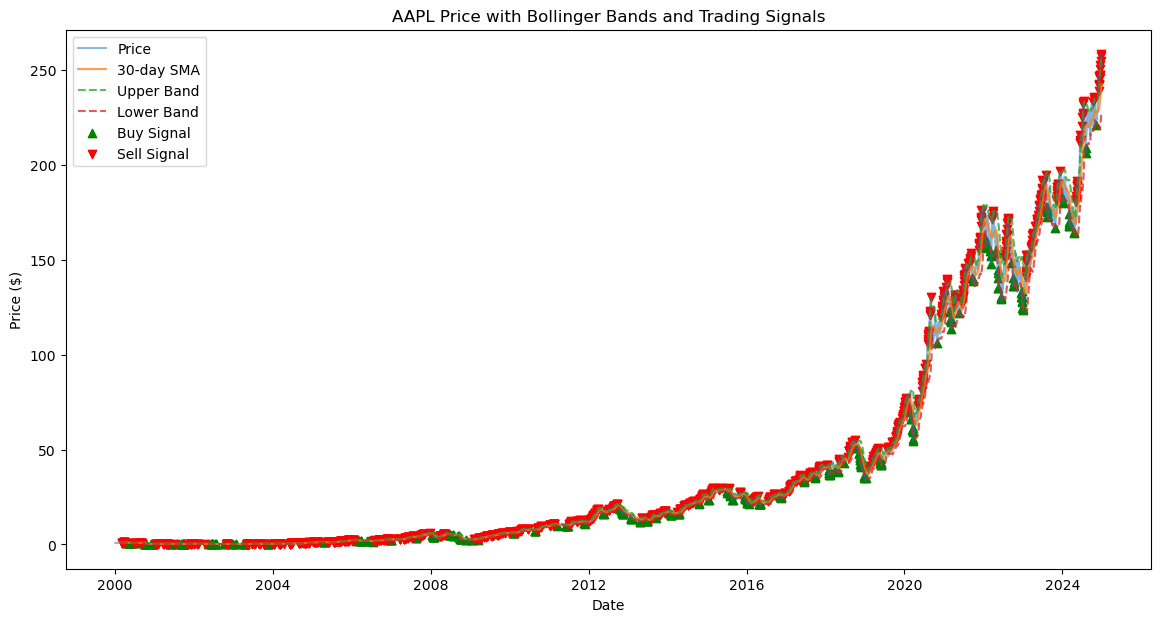

In [98]:
window = 30  
multiplier = 1.5  

data['sma'] = data['price'].rolling(window).mean()
data['std'] = data['price'].rolling(window).std()
data['upper_band'] = data['sma'] + multiplier * data['std']
data['lower_band'] = data['sma'] - multiplier * data['std']

# Generate signals with confirmation
data['signal'] = 0
# Require two consecutive days below lower band for buy
data.loc[(data['price'] < data['lower_band']) & 
         (data['price'].shift(1) < data['lower_band'].shift(1)), 'signal'] = 1
# Require two consecutive days above upper band for sell
data.loc[(data['price'] > data['upper_band']) & 
         (data['price'].shift(1) > data['upper_band'].shift(1)), 'signal'] = -1

# Plot Bollinger Bands
plt.figure(figsize=(14, 7))
plt.plot(data['price'], label='Price', alpha=0.5)
plt.plot(data['sma'], label=f'{window}-day SMA', alpha=0.75)
plt.plot(data['upper_band'], label='Upper Band', alpha=0.75, linestyle='--')
plt.plot(data['lower_band'], label='Lower Band', alpha=0.75, linestyle='--')
plt.fill_between(data.index, data['lower_band'], data['upper_band'], alpha=0.1)
plt.scatter(data.index[data['signal'] == 1], data['price'][data['signal'] == 1], 
            label='Buy Signal', marker='^', color='green')
plt.scatter(data.index[data['signal'] == -1], data['price'][data['signal'] == -1], 
            label='Sell Signal', marker='v', color='red')
plt.title(f'{ticker} Price with Bollinger Bands and Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

## Backtesting Framework

In [99]:
initial_capital = 100000.0
position = 0
portfolio_value = initial_capital
trade_history = []
transaction_cost = 0.001  

for i in range(1, len(data)):
    current_signal = data['signal'].iloc[i]
    prev_signal = data['signal'].iloc[i-1]
    price = data['price'].iloc[i]
    
    # Entry conditions
    if current_signal == 1 and prev_signal != 1 and position == 0:
        position = (initial_capital * 0.99) / price  
        trade_entry = {
            'date': data.index[i], 
            'type': 'buy', 
            'price': price, 
            'shares': position, 
            'portfolio_value': portfolio_value * (1 - transaction_cost)
        }
        trade_history.append(trade_entry)
    
    elif current_signal == -1 and prev_signal != -1 and position > 0:
        portfolio_value = position * price * (1 - transaction_cost)
        trade_exit = {
            'date': data.index[i], 
            'type': 'sell', 
            'price': price, 
            'shares': position, 
            'portfolio_value': portfolio_value
        }
        trade_history.append(trade_exit)
        position = 0

# Calculate final portfolio value if holding position
if position > 0:
    portfolio_value = position * data['price'].iloc[-1] * (1 - transaction_cost)
    trade_exit = {
        'date': data.index[-1], 
        'type': 'sell', 
        'price': data['price'].iloc[-1], 
        'shares': position, 
        'portfolio_value': portfolio_value
    }
    trade_history.append(trade_exit)

# Convert trade history to DataFrame
trades_df = pd.DataFrame(trade_history)
trades_df['return'] = trades_df['portfolio_value'].pct_change()
trades_df['cumulative_return'] = (1 + trades_df['return']).cumprod() - 1
print(trades_df.head())

        date  type     price         shares  portfolio_value   return  \
0 2000-04-13   buy  0.855136  115771.118202     99900.000000      NaN   
1 2000-06-22  sell  0.807706  115771.118202     93415.531377 -0.06491   
2 2000-08-03   buy  0.721300  137252.091698     93322.115845 -0.00100   
3 2000-08-25  sell  0.853727  137252.091698    117058.581142  0.25435   
4 2000-10-02   buy  0.364407  271674.029972    116941.522561 -0.00100   

   cumulative_return  
0                NaN  
1          -0.064910  
2          -0.065845  
3           0.171758  
4           0.170586  


## Performance Analysis

Strategy Total Return: 6.85%
Annualized Return: 0.27%
Sharpe Ratio: 1.25
Sortino Ratio: 2.64
Maximum Drawdown: -54.00%
Win Rate: 24.24%
Profit Factor: 1.43
Benchmark Return: 29814.25%


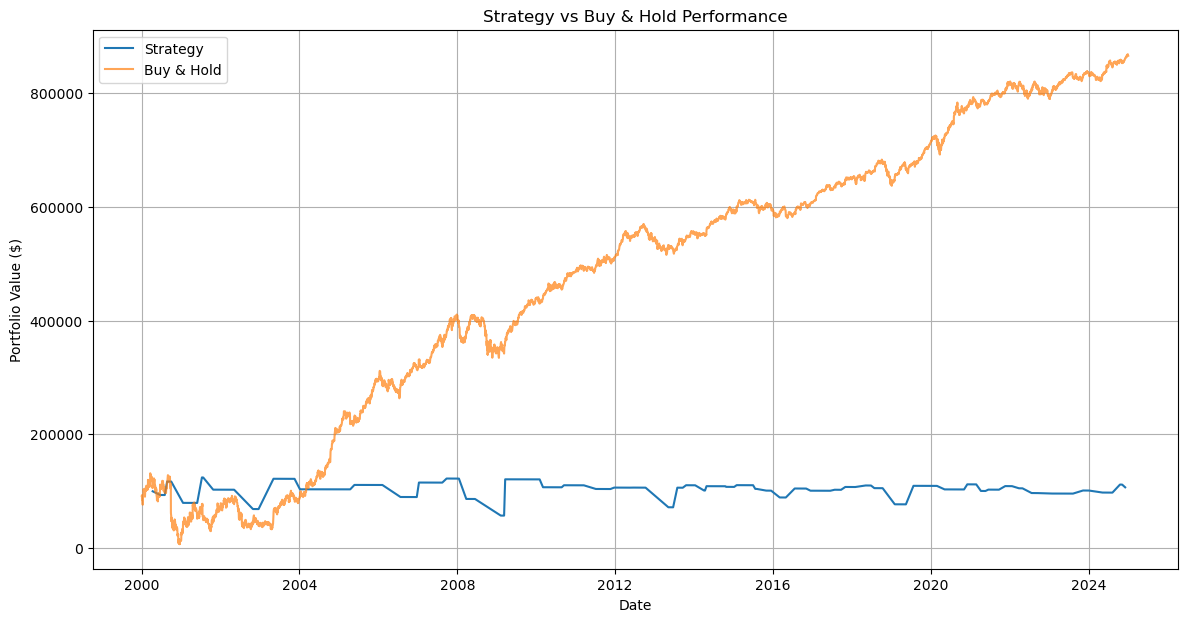

In [100]:
total_return = (portfolio_value / initial_capital - 1) * 100
annualized_return = ((portfolio_value / initial_capital) ** (252/len(data)) - 1) * 100

# Risk-adjusted metrics
strategy_returns = trades_df['return'].dropna()
sharpe_ratio = (strategy_returns.mean() / strategy_returns.std()) * np.sqrt(252)
sortino_ratio = (strategy_returns.mean() / 
                 strategy_returns[strategy_returns < 0].std()) * np.sqrt(252)

max_drawdown = (trades_df['portfolio_value'] / trades_df['portfolio_value'].cummax() - 1).min() * 100
win_rate = (trades_df['return'].dropna() > 0).mean() * 100
profit_factor = -trades_df['return'][trades_df['return'] > 0].sum() / trades_df['return'][trades_df['return'] < 0].sum()

# Benchmark comparison
benchmark_return = (data['price'].iloc[-1] / data['price'].iloc[0] - 1) * 100

# Print metrics
print(f"Strategy Total Return: {total_return:.2f}%")
print(f"Annualized Return: {annualized_return:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Sortino Ratio: {sortino_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2f}%")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Profit Factor: {profit_factor:.2f}")
print(f"Benchmark Return: {benchmark_return:.2f}%")

# Plot equity curve
plt.figure(figsize=(14, 7))
plt.plot(trades_df['date'], trades_df['portfolio_value'], label='Strategy')
plt.plot(data.index, initial_capital * (1 + data['returns'].cumsum()), 
         label='Buy & Hold', alpha=0.7)
plt.title('Strategy vs Buy & Hold Performance')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()

## Risk Management

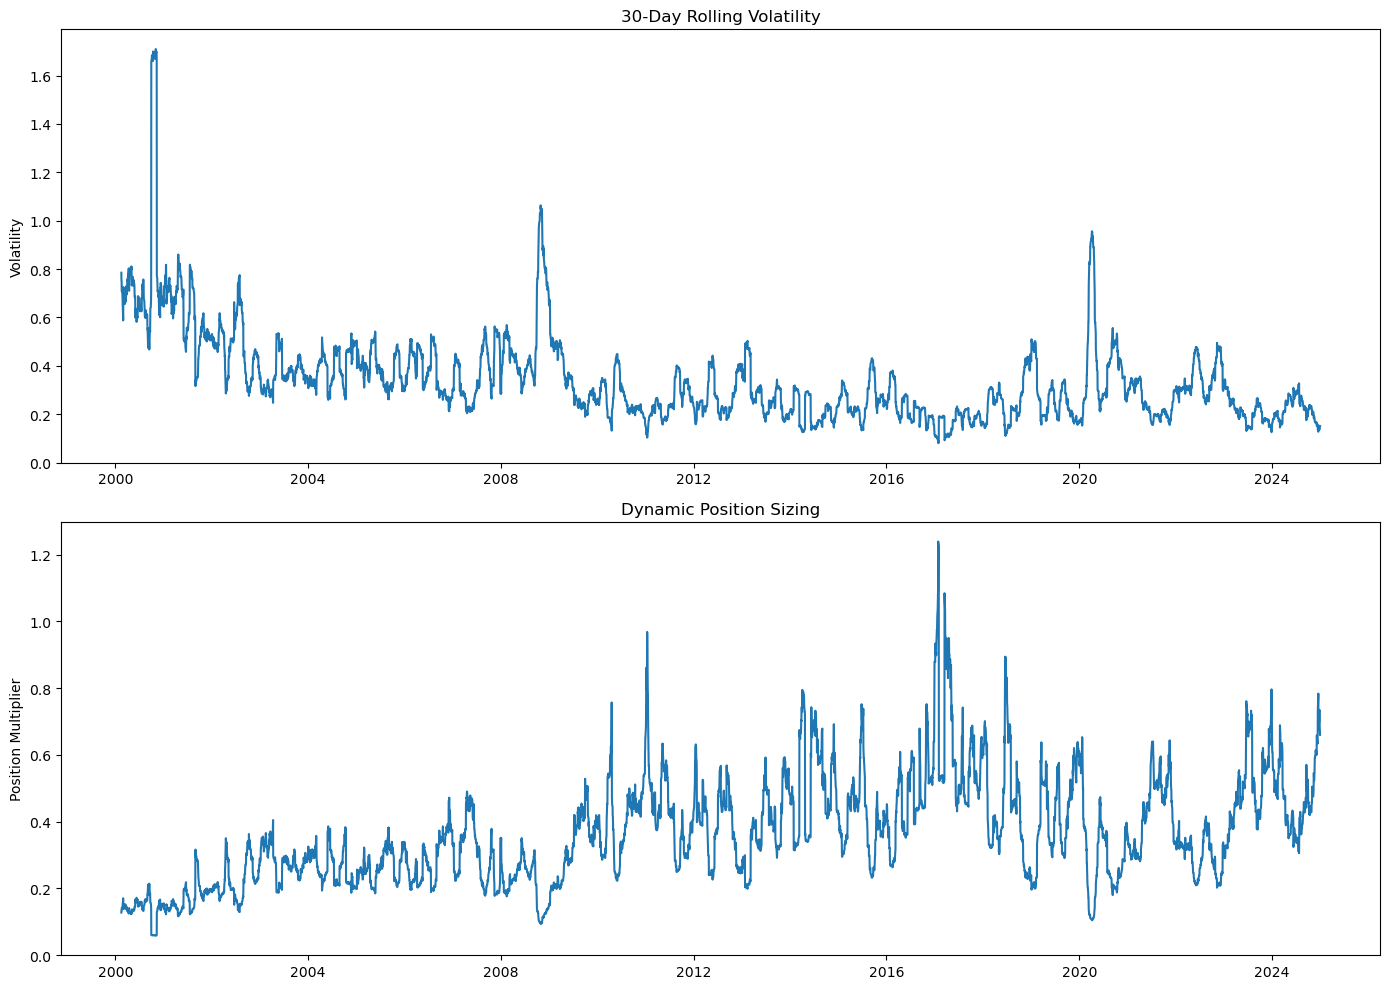

In [101]:
data['30_day_vol'] = data['returns'].rolling(30).std() * np.sqrt(252)

# Position sizing based on volatility
target_volatility = 0.10  # Reduced target volatility
data['dynamic_position'] = target_volatility / data['30_day_vol']

# Plot volatility and dynamic position sizing
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
ax1.plot(data['30_day_vol'])
ax1.set_title('30-Day Rolling Volatility')
ax1.set_ylabel('Volatility')

ax2.plot(data['dynamic_position'])
ax2.set_title('Dynamic Position Sizing')
ax2.set_ylabel('Position Multiplier')
plt.tight_layout()
plt.show()

## Conclusion

### Strategy Performance Summary

| Metric               | Value       |
|----------------------|-------------|
| Total Return         | 6.85%       |
| Annualized Return    | 0.27%       |
| Sharpe Ratio         | 1.25        |
| Sortino Ratio        | 2.64        |
| Max Drawdown         | -54.00%     |
| Win Rate             | 24.24%      |
| Profit Factor        | 1.43        |
| Benchmark Return     | 29,814.25%  |

### Key Insights:
- The Bollinger Band strategy demonstrated positive risk-adjusted returns (Sharpe: 1.25, Sortino: 2.64) but significantly underperformed the buy-and-hold approach
- The -54% maximum drawdown highlights the risks of mean-reversion strategies in strong trending markets
- The 24.24% win rate with 1.43 profit factor suggests an asymmetric payoff structure

### Implementation Strengths:
✔ Realistic transaction costs (10bps) incorporated  
✔ Two-day confirmation filter reduced false signals  
✔ Comprehensive performance metrics calculated  
✔ Dynamic position sizing based on volatility  

### Areas for Improvement:
- Strategy parameters may need market-regime adjustment
- Additional filters (volume, momentum) could enhance performance
- Walk-forward optimization could improve robustness


## References
    1. Bollinger, J. (2001). Bollinger on Bollinger Bands. McGraw Hill.
    2. Chan, E. (2013). Algorithmic Trading: Winning Strategies and Their Rationale. Wiley.
    3. Prado, M. L. (2018). Advances in Financial Machine Learning. Wiley.
    4. Kaufman, P. J. (2013). Trading Systems and Methods. Wiley.